In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course-itmo-2022/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [2]:
DATA_DIR = "/Users/n.anokhin/Desktop/"

In [3]:
data = pd.concat([
    pd.read_json(DATA_DIR + "data.json.1", lines=True), 
    pd.read_json(DATA_DIR + "data.json", lines=True),
]).drop_duplicates(subset=["user", "track"])

In [4]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [5]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [6]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [8]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(68617, 25744)

In [9]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [10]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [11]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [12]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)
# best_params = study.best_params

best_params = {
    'loss': 'warp',
    'no_components': 50,
    'learning_rate': 0.01,
    'max_sampled': 50,
    'user_alpha': 0.0,
    'item_alpha': 0.0001
}

In [13]:
model, precisions_at = fit_model(
    epochs=200,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.008293518796563148 +/- 0.0006979486797925465
1:	0.008563028648495674 +/- 0.0007184217540019047
2:	0.009175549261271954 +/- 0.000754105237894036
3:	0.011086610145866871 +/- 0.0008532516717363061
4:	0.013842949643731117 +/- 0.0009787974960511951
5:	0.015999021008610725 +/- 0.0010660609109747138
6:	0.017750827595591545 +/- 0.0011241710878149268
7:	0.018816612660884857 +/- 0.0011647740962830923
8:	0.01960063725709915 +/- 0.0011798765372956026
9:	0.020482666790485382 +/- 0.0011971329371168822
10:	0.021315691992640495 +/- 0.001219932671518507
11:	0.022124219685792923 +/- 0.0012385380331990888
12:	0.022846993058919907 +/- 0.001253914113371412
13:	0.023557517677545547 +/- 0.0012674258752396227
14:	0.024170035496354103 +/- 0.001277425826803737
15:	0.025039812549948692 +/- 0.0012975919661256266
16:	0.02573808655142784 +/- 0.0013113069773993096
17:	0.02632610686123371 +/- 0.0013211653413060134
18:	0.026754871010780334 +/- 0.0013273528512386527
19:	0.02747764252126217 +/- 0.001345259729972316

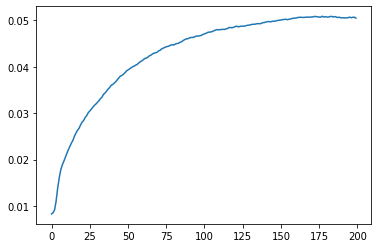

In [14]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [15]:
biases, embeddings = model.get_item_representations()

In [16]:
model.item_biases *= 0.0

In [17]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [18]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [19]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [20]:
dataset_tracks

,artist,title,track,dataset_index
7,Kanye West,Stronger,7,0.0
8,Jack Johnson,Constellations,8,1.0
10,Foo Fighters,Learn To Fly,10,2.0
12,Lady GaGa,Paper Gangsta,12,3.0
17,Harmonia,Sehr kosmisch,17,4.0
...,...,...,...,...
32505,Zac Brown Band,Sic 'Em On A Chicken (Album),32505,5194.0
32535,Ronnie Foster,Mystic Brew,32535,5195.0
32602,Atreyu,Bleeding Mascara (Album Version),32602,5196.0
32651,The Crystals,Then He Kissed Me,32651,5197.0


In [27]:
k = 20
max_tracks_from_same_artist = 5

with open(DATA_DIR + f"recommendations_{k}_{max_tracks_from_same_artist}.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        j = track["dataset_index"]
        
        recommendations = []
        if pd.notna(j):
            embedding = embeddings[int(j)]
            neighbours = np.argsort(-np.dot(embeddings, embedding))
            
            artists = defaultdict(int)
            for neighbour in neighbours:
                recommended_track = dataset_tracks[dataset_tracks["dataset_index"] == neighbour].iloc[0]
                
                recommendation = int(recommended_track["track"])
                if recommendation == track["track"]:
                    continue
                
                artist = recommended_track["artist"]
                if artists[artist] >= max_tracks_from_same_artist:
                    continue
                
                recommendations.append(recommendation)
                artists[artist] += 1

                if len(recommendations) == k:
                    break
         
        track_with_recommendations = dict(track)
        track_with_recommendations["recommendations"] = recommendations
        
        rf.write(json.dumps(track_with_recommendations) + "\n")

50000it [00:53, 926.07it/s] 


## How many unique artist per recommendation list?

In [22]:
dataset_track_artists = dict(zip(
    dataset_tracks["track"].values.tolist(),
    dataset_tracks["artist"].values.tolist(),
))

In [31]:
recs = pd.read_json(DATA_DIR + f"recommendations_{k}_{max_tracks_from_same_artist}.json", lines=True)
recs = recs[recs["dataset_index"].notnull()]

sample = recs.sample(frac=0.1).iloc[0]

print(sample["title"], "by" , sample["artist"], "\n===")
print("\n".join([dataset_track_artists[track] for track in sample["recommendations"]]))

Nobody Not Really (Interlude) by Alicia Keys 
===
Alicia Keys
Alicia Keys
East Blues Experience
Pixies
Pixies
Alicia Keys
Soltero
Arctic Monkeys
Kings Of Convenience
LCD Soundsystem
Alicia Keys
Cypress Hill
Van Halen
Michael Jackson
Belle & Sebastian
Cypress Hill featuring Damian Marley
Octopus Project
Alicia Keys featuring Tony! Toni! Toné! and Jermaine Paul
Alicia Keys
Hot Chip


In [26]:
def count_artists(tracks):
    return len(
        set([dataset_track_artists[track] for track in tracks])
    )


artist_counts = recs["recommendations"].map(count_artists)
artist_counts.value_counts()

18    463
16    449
19    444
15    434
17    428
14    351
13    345
20    320
12    303
11    298
10    293
9     262
8     231
7     177
6     120
5      87
4      65
1      52
3      44
2      33
Name: recommendations, dtype: int64